# Project 2: A new measurement of the Hubble constant using Fast Radio Bursts

In [3]:
using QuadGK, LinearAlgebra, Plots, XLSX, LaTeXStrings, Roots, Distributions

ArgumentError: ArgumentError: Package Roots not found in current path:
- Run `import Pkg; Pkg.add("Roots")` to install the Roots package.


Reading the data

In [209]:
read_data = XLSX.readxlsx("project2data.xlsx")

XLSXFile("project2data.xlsx") containing 1 Worksheet
            sheetname size          range        
-------------------------------------------------
               Sheet1 10x4          A1:D10       


In [210]:
data = read_data["Sheet1"][:]

10×4 Matrix{Any}:
 "Name"          "Redshift"     "Measured DM"     "Milky Way DM"
 "FRB 180916★"  0.0337       348.8             199
 "FRB 190608★"  0.1178       338.7              37.2
 "FRB 121102"   0.19273      558               188
 "FRB 190102"   0.291        363.6              57.3
 "FRB 180924"   0.3214       361.42             40.5
 "FRB 190611★"  0.378        321.4              57.8
 "FRB 181112"   0.4755       589.27            102
 "FRB 190711"   0.522        593.1              56.4
 "FRB 190523"   0.66         760.8              37

In [211]:
redshift_z = convert.(Float64,data[2:end,2])
DM_measured = convert.(Float64,data[2:end,3])
DM_measured[7] = DM_measured[7] - 85
DM_MW = convert.(Float64,data[2:end,4])
sigma_MW = 30

30

We subtracted 85 from the FRB 181112 since it had dispersion measure contribution from another galaxy as well.

The dispersion measure due to the large scale structure ($DM_{LSS}$) is given by:
$$ DM_{LSS}(z) = \frac{3\Omega_{b}cH_0}{8\pi Gm_p}\chi_{e} f_{IGM} \int_{0}^{z}\frac{1+z^{\prime}}{E(z^\prime)} dz^\prime $$  
where $E(z)$ is given by:
$$ E(z) = \sqrt{\Omega_m (1+z)^3 + 1-\Omega_m} $$

Loading the values of the parameters:

In [212]:
chi_e = 0.88
f_IGM = 0.84
omega_m_hsq = 0.143
omega_b_hsq = 0.02237
G = 6.6743e-11
m_p = 1.67262192369e-27
c = 2.99792458e8

prefactor = 300*omega_b_hsq*chi_e*f_IGM*c/(8*pi*G*m_p*3.0857e22*3.0857e19)

556.6973200932946

The prefactor has been divided by some numerical conversion factors so that the resulting dispersion measure has the required units of $[\textnormal{pc cm}^{-3}]$

Writing $H_0 = 100h$, the $DM_{LSS}(z)$ integral can be rewritten so that we can make use of known constant values:
$$ DM_{LSS}(z) = \frac{300 c(\Omega_b h^2)}{8\pi Gm_p} \chi_{e} f_{IGM} \int_{0}^{z} \frac{1+z^\prime}{\sqrt{(\Omega_m h^2)(1+z^\prime)^3 - (\Omega_m h^2) + h^2}} dz^\prime $$

Defining functions that give us useful outputs for computations:

In [213]:
integrand(z,h) = (1+z)/sqrt(omega_m_hsq*(1+z)^3 - omega_m_hsq + h^2) # The integrand
distr(h, uplim) = prefactor*quadgk(z -> integrand(z,h), 0, uplim)[1] # Returns a distribution for h

distr (generic function with 1 method)

In [214]:
sigma_LSS(z) = 140*z + 40 # Linear interpolation between (0,140) and (1,180)
DM_host(z) = 100/(1+z) # Mean of Gaussian, <DM_host>(z_i)
sigma_host(z) = 50/(1+z) # Standard deviation of Gaussian, sigma_host(z_i) 

sigma_host (generic function with 1 method)

## Likelihood Analysis

The Gaussian (individual) likelihood is given by:
$$ \mathcal{L}(DM_i, z_i) = \frac{1}{\sqrt{2\pi \sigma_i^2}} \exp\bigg(-\frac{(DM_i - DM^{theo}(z_i))^2}{2 \sigma_i^2}\bigg) $$
where
\begin{aligned}
DM_i &= DM_{measured} - DM_{MW} \\ DM^{theo}(z_i) &= DM_{LSS}(z_i) + \langle DM_{host} \rangle (z_i) \\ \sigma_i^2 &= \sigma_{host}^2 (z_i) + \sigma_{LSS}^2 (z_i) + \sigma_{MW}^2 \\
\end{aligned}

Then the joint likelihood is given by:
$$ \mathcal{L}_{tot} = \prod_{i} \mathcal{L}_i $$

In [215]:
function likelihood(hrange, DM_measured, DM_MW, DM_host, redshift)
    sigmasq = (sigma_host(redshift))^2 + (sigma_LSS(redshift))^2 + sigma_MW^2
    DM_obs = DM_measured - DM_MW
    DM_theo = DM_host .+ distr.(hrange,redshift) 

    return (1/sqrt(2*pi*sigmasq))*exp.(-(DM_obs .- DM_theo).^2 ./ (2*sigmasq))
    
end

function all_likelihoods(hrange, DM_measured, DM_MW, redshift)
    n = length(redshift)
    tl = 1
    likelihoods = [likelihood(hrange, DM_measured[i], DM_MW[i], DM_host(redshift[i]), redshift[i]) for i in 1:n]
    for i in 1:n
        tl = tl .* likelihoods[i]
    end
    return likelihoods, tl
end

all_likelihoods (generic function with 1 method)

In [216]:
function plot_likelihoods(hrange, likelihoods, total_likelihood, redshift)
    plot()
    for i in 1:length(likelihoods)
        plot!(100*hrange, likelihoods[i]/norm(likelihoods[i]), label=redshift[i])
    end
    plot!(100*hrange, total_likelihood/(norm(total_likelihood)), label="all", lw=3, gridlw = 2)
    xlabel!(L"H_0 ~ \textnormal{[km~s^{-1}~Mpc^{-1}]}")
    ylabel!("Probability Density")
    title!("Likelihoods for different Redshifts")
end

plot_likelihoods (generic function with 1 method)

In [217]:
hrange = LinRange(0.2,1.1,1000);
likelihoods, tl = all_likelihoods(hrange, DM_measured, DM_MW, redshift_z);

In [218]:
tl # joint total likelihood

1000-element Vector{Float64}:
 7.123555604418135e-44
 9.73824806959071e-44
 1.3286386822677783e-43
 1.8091750213838392e-43
 2.458710817471622e-43
 3.3349782521861454e-43
 4.514843621471357e-43
 6.100451773599851e-43
 8.227279501754462e-43
 1.1074670715291207e-42
 1.4879591916796418e-42
 1.9954558322179504e-42
 2.6710951187190473e-42
 ⋮
 2.0275693478627758e-25
 2.0037163382741949e-25
 1.9801395743025903e-25
 1.9568359991661055e-25
 1.9338025866055497e-25
 1.9110363406497794e-25
 1.8885342953813222e-25
 1.866293514702327e-25
 1.8443110921009497e-25
 1.8225841504180013e-25
 1.8011098416141908e-25
 1.7798853465377283e-25

Now, estimating the Hubble's constant using the maximum likelihood estimator!

In [219]:
H_0_val = 100*hrange[findmax(tl)[2]]
H_0_val_std = 100*std(tl/norm(tl))
println("Estimated value of Hubble constant = ",H_0_val," ± ",H_0_val_std)

Estimated value of Hubble constant = 69.72972972972974 ± 2.412400308986277


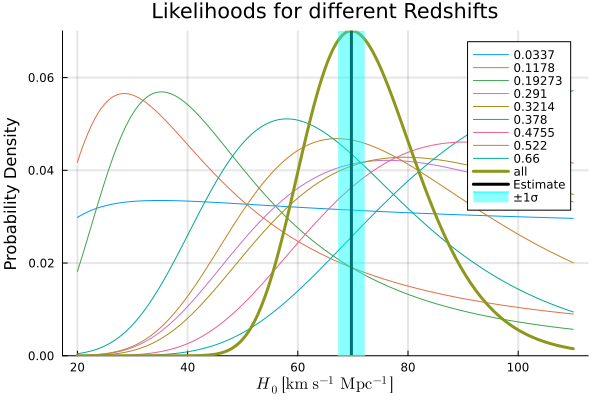

In [220]:
xval_plot = collect(range(H_0_val-H_0_val_std, H_0_val+H_0_val_std, 100));
yval1_plot = zeros(100);
yval2_plot = findmax(tl/norm(tl))[1]*ones(100);
plot_likelihoods(hrange, likelihoods, tl, redshift_z)
vline!([H_0_val], label="Estimate", lw=3, color="black", ylims=[0,findmax(tl/norm(tl))[1]])
plot!(xval_plot, yval1_plot, fillrange = yval2_plot, fillalpha = 0.45, color="aqua", label="±1σ")

Now, we use the estimated $H_{0}$ value to find the best-fit line for $DM_{LSS}$

In [221]:
best_fit_vals_func(redshift) = distr.(H_0_val/100,redshift) # Returns DM_LSS for the estimated value of Hubble's constant

best_fit_vals_func (generic function with 1 method)

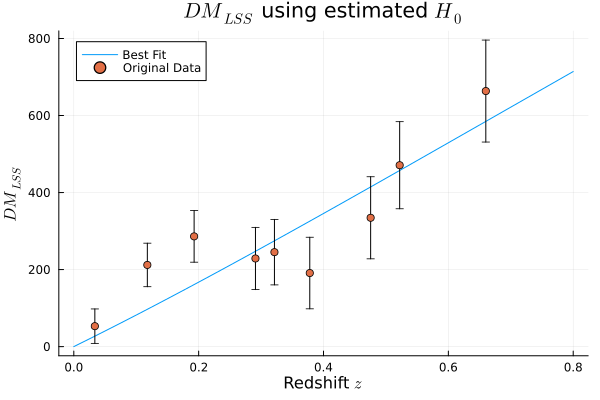

In [222]:
plot(LinRange(0,0.8,100), best_fit_vals_func(LinRange(0,0.8,100)), label="Best Fit")
scatter!(redshift_z,DM_measured .- DM_MW .- DM_host.(redshift_z), yerror=sigma_LSS.(redshift_z) , label="Original Data")
xlabel!("Redshift "*L"z")
ylabel!(L"DM_{LSS}")
title!(L"DM_{LSS}"*" using estimated "*L"H_0")

## Generating Mock Data for further analysis

The redshift dsitribution is given as:
$$ n(z) = z^2 \exp(-\alpha z) $$
with $\alpha = 7$

This is nothing but the unnormalized Gamma distribution!

In [223]:
redshift_distribution = Gamma(3,1/7)
CDF_distribution(z) = cdf(redshift_distribution,z) # Returns the CDF of a particular z

CDF_distribution (generic function with 1 method)

Plotting the CDF

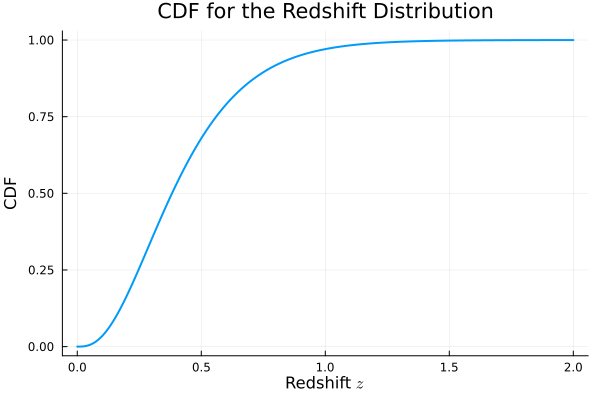

In [224]:
mock_x = LinRange(0,2,1000)
mock_y = CDF_distribution.(mock_x)
plot(mock_x,mock_y, xlabel="Redshift "*L"z", ylabel="CDF", legend=false, title="CDF for the Redshift Distribution", lw=2)

Now we define a function that will return the redshift value given a CDF value drawn randomly from a Uniform distribution $~\mathcal{U}[0,1]$

In [225]:
redshift_sample(unif_sample) = quantile(redshift_distribution,unif_sample) # Returns the redshift value

redshift_sample (generic function with 1 method)

Drawing random samples and finding their redshift values:

In [226]:
unif_sample_test = rand(500) # Samples from Uniform Distribution
redshift_cal_test = redshift_sample.(unif_sample_test) # Redshift values for the Uniform Samples drawn

500-element Vector{Float64}:
 0.43159563111122984
 1.1994181728763817
 0.4057658766800729
 0.11568017496758218
 0.15180057591215976
 0.3030289536710546
 0.06469027714991704
 0.6532464230797278
 0.5001535934491259
 0.5024485484057907
 0.4215693550442086
 0.27856037323308225
 0.6583379332117573
 ⋮
 0.2139084290232272
 0.5871193926487659
 0.6947710460867599
 0.3616851784637044
 0.4337424346568911
 0.7840170082760408
 0.9104136647809057
 0.25012052920857614
 0.36762410266010015
 0.1785398068317022
 0.25421818342599073
 0.625790460199871

Plotting the redshift values obtained to verify that they follow the Gamma distribution stated above:

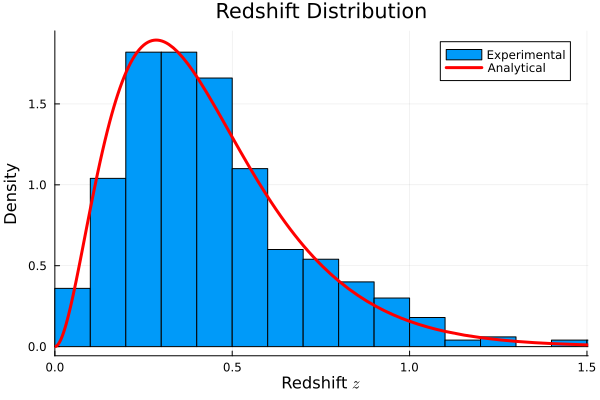

In [227]:
analytic_form(z) = 0.5*7^3*z^2 * exp(-7*z)
histogram(redshift_cal_test, xlabel="Redshift "*L"z", ylabel="Density", title="Redshift Distribution" , normalize=true, label="Experimental")
plot!(analytic_form, xlims=[0,findmax(redshift_cal_test)[1]], color="red", lw=3, label = "Analytical")

Finding the best-fit $DM_{LSS}$ values for the sampled redshift values:

In [228]:
best_fit_vals = best_fit_vals_func(redshift_cal_test) # DM LSS using the integral and calculated value of Hubble's constant

500-element Vector{Float64}:
  374.4294379727229
 1078.5390038521791
  350.8983346821727
   95.10028955616892
  125.79361299195409
  258.2429581864978
   52.53773062628579
  578.5120388156174
  437.22224159651796
  439.33126109061726
  365.2860522599233
  236.447628937416
  583.2232334075771
    ⋮
  179.49178070960818
  517.3687764806165
  616.9395174486184
  310.94083821173876
  376.38867538778624
  699.4867424804985
  815.9785655495041
  211.27341448980278
  316.3080680637147
  148.77757275842092
  214.88945208162573
  553.1132083109513

Let us add some noise to the best-fit values for fun:

In [229]:
# Adding Gaussian Noise to best-fit values
noisy_data = best_fit_vals .+ 10*rand(Normal(0,1),500)

500-element Vector{Float64}:
  374.98737773130483
 1058.023155298563
  348.5328508512517
   92.02238425460698
  115.29944353114449
  252.6118075044284
   55.470561714440144
  587.8795310499098
  444.23565044722756
  437.8800487312736
  358.5707222431673
  248.03881154953424
  576.0375404216206
    ⋮
  148.23851582401568
  531.5129665367416
  610.9777091734616
  317.68426307677566
  365.41104711920804
  693.6560386007392
  820.8528713272018
  207.41548927452007
  309.2577623652032
  140.4941735006688
  209.89015396472993
  542.7498718385937

Plotting the original data, the best-fit and the noisy best-fit values:

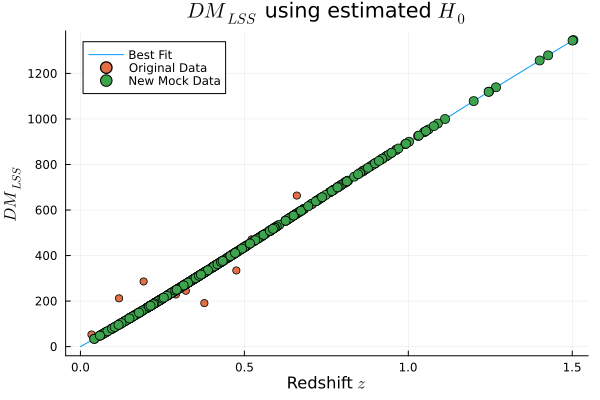

In [230]:
plot(LinRange(0,1.5,100), best_fit_vals_func(LinRange(0,1.5,100)), label="Best Fit", xlabel="Redshift "*L"z", ylabel=L"DM_{LSS}", title=L"DM_{LSS}"*" using estimated "*L"H_0")
scatter!(redshift_z,DM_measured .- DM_MW .- DM_host.(redshift_z), label="Original Data")
scatter!(redshift_cal_test, best_fit_vals, label="New Mock Data", markersize=5)

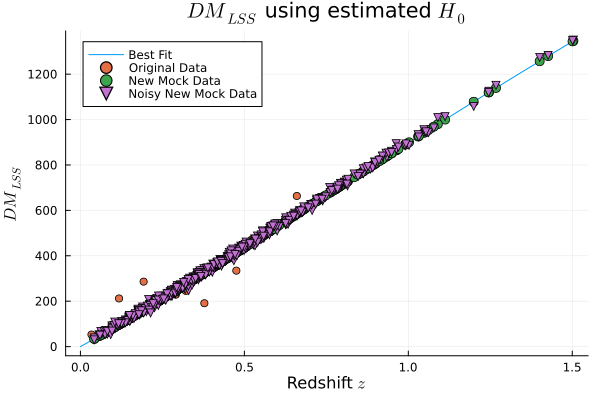

In [231]:
scatter!(redshift_cal_test, noisy_data, label="Noisy New Mock Data", marker=:dtriangle)

Clearly, we can see the noisy data deviates from the best-fit line which is expected!

Now, we perform a back test of our computations. We calculate the CDF of the sampled redshift values to see if we are able to reproduce our original uniformly distributed samples:

In [232]:
backtesting = CDF_distribution.(redshift_cal_test)
backtesting ≈ unif_sample_test

true

Hence, the back test is successful since both the samples are nearly equal. Errors, if any, are negligible. To quantify the same, we perform the following computations using the two samples:

In [233]:
backtesting .- unif_sample_test

500-element Vector{Float64}:
  0.0
  0.0
 -1.1102230246251565e-16
 -1.3877787807814457e-17
  1.3877787807814457e-17
  0.0
 -1.0408340855860843e-17
  0.0
  0.0
  1.1102230246251565e-16
  1.1102230246251565e-16
  0.0
  0.0
  ⋮
  2.7755575615628914e-17
  0.0
  0.0
 -5.551115123125783e-17
  0.0
  0.0
  0.0
  5.551115123125783e-17
 -5.551115123125783e-17
  0.0
 -1.1102230246251565e-16
  0.0

Clearly, the difference in elements of the two samples is either 0 or extremely extremely small! 

Further, its mean value is:

In [234]:
mean(backtesting .- unif_sample_test)

-3.411333715508391e-18

It can be seen clearly that the value of the mean is highly insignificant and can safely assumed to be zero!